In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import optuna.integration.lightgbm as opt_lgb

import warnings



In [2]:
#データ取得
data_tmp = pd.read_csv("./main/data/train.csv")

#data_tmp = data_tmp[:500].reset_index()
#data_tmp = data_tmp.drop("index", axis = 1)


#目的の変数
y = data_tmp["HeartDisease"]

#テストファイル入れる
data_test = pd.read_csv("./main/data/train.csv")

#data_test = data_test[500:].reset_index()
#data_test = data_test.drop("index", axis = 1)

#目的の変数
y_data_test = data_test["HeartDisease"]

In [3]:
#訓練データ加工 =================
#K_ChestPainGroupと差別化のため修正
data_tmp['G_ChestPainType'] = data_tmp['ChestPainType']
data_tmp.loc[data_tmp['ChestPainType']=='ASY','G_ChestPainType']='G_ASY'
data_tmp.loc[data_tmp['ChestPainType']=='NAP','G_ChestPainType']='G_TA+NAP'
data_tmp.loc[data_tmp['ChestPainType']=='TA','G_ChestPainType']='G_TA+NAP'
data_tmp.loc[data_tmp['ChestPainType']=='ATA','G_ChestPainType']='G_ATA'

In [4]:
#テストデータ加工 =================

data_test['G_ChestPainType'] = data_test['ChestPainType']
data_test.loc[data_test['ChestPainType']=='ASY','G_ChestPainType']='G_ASY'
data_test.loc[data_test['ChestPainType']=='NAP','G_ChestPainType']='G_TA+NAP'
data_test.loc[data_test['ChestPainType']=='TA','G_ChestPainType']='G_TA+NAP'
data_test.loc[data_test['ChestPainType']=='ATA','G_ChestPainType']='G_ATA'

In [5]:
#ChestPain_groupの作成
data_tmp['K_ChestPain_group'] = data_tmp['ChestPainType']
data_tmp.loc[(data_tmp['K_ChestPain_group'] == 'ASY') , 'K_ChestPain_group'] = 'K_ASY' 
data_tmp.loc[(data_tmp['K_ChestPain_group'] == 'NAP') , 'K_ChestPain_group'] = 'K_NAP' 
data_tmp.loc[(data_tmp['K_ChestPain_group'] == 'ATA') | (data_tmp['K_ChestPain_group'] == 'TA'), 'K_ChestPain_group'] = 'K_ATA/TA' #ATAとTAをグループ化

In [6]:
#ChestPain_groupの作成
data_test['K_ChestPain_group'] = data_test['ChestPainType']
data_test.loc[(data_test['K_ChestPain_group'] == 'ASY') , 'K_ChestPain_group'] = 'K_ASY' 
data_test.loc[(data_test['K_ChestPain_group'] == 'NAP') , 'K_ChestPain_group'] = 'K_NAP' 
data_test.loc[(data_test['K_ChestPain_group'] == 'ATA') | (data_test['K_ChestPain_group'] == 'TA'), 'K_ChestPain_group'] = 'K_ATA/TA' #ATAとTAをグループ化

In [7]:
#KNN用
data_tmp['CholCat']='chol1_0'
for i in range(len(data_tmp)):
    if 200>data_tmp.loc[i,'Cholesterol']>0:
        data_tmp.loc[i,'CholCat']='chol1_1'
    elif 320>data_tmp.loc[i,'Cholesterol']>=200:
        data_tmp.loc[i,'CholCat']='chol1_2'
    elif data_tmp.loc[i,'Cholesterol']>=320:
        data_tmp.loc[i,'CholCat']='chol1_3'
    else:
        pass

In [8]:
data_test['CholCat']='chol1_0'
for i in range(len(data_test)):
    if 200>data_test.loc[i,'Cholesterol']>0:
        data_test.loc[i,'CholCat']='chol1_1'
    elif 320>data_test.loc[i,'Cholesterol']>=200:
        data_test.loc[i,'CholCat']='chol1_2'
    elif data_test.loc[i,'Cholesterol']>=320:
        data_test.loc[i,'CholCat']='chol1_3'
    else:
        pass

In [9]:
#訓練データ前処理：LR用
#G_CholCatの作成
data_tmp['G_CholCat']='chol0'
for i in range(len(data_tmp)):
    if 200>data_tmp.loc[i,'Cholesterol']>0:
        data_tmp.loc[i,'G_CholCat']='chol1'
    if 240>data_tmp.loc[i,'Cholesterol']>=200:
        data_tmp.loc[i,'G_CholCat']='chol2'
    elif 280>data_tmp.loc[i,'Cholesterol']>=240:
        data_tmp.loc[i,'G_CholCat']='chol3'
    elif data_tmp.loc[i,'Cholesterol']>=280:
        data_tmp.loc[i,'G_CholCat']='chol4'
    else:
        pass

In [10]:
#G_CholCatの作成
data_test['G_CholCat']='chol0'
for i in range(len(data_test)):
    if 200>data_test.loc[i,'Cholesterol']>0:
        data_test.loc[i,'G_CholCat']='chol1'
    if 240>data_test.loc[i,'Cholesterol']>=200:
        data_test.loc[i,'G_CholCat']='chol2'
    elif 280>data_test.loc[i,'Cholesterol']>=240:
        data_test.loc[i,'G_CholCat']='chol3'
    elif data_test.loc[i,'Cholesterol']>=280:
        data_test.loc[i,'G_CholCat']='chol4'
    else:
        pass


In [11]:
# 訓練データ、LR用
# G_H_riskの作成
data_tmp['G_H_risk']='Risk0'
for i in range(len(data_tmp)):
    if abs(data_tmp.loc[i,'Oldpeak'])<0.3 and data_tmp.loc[i,'ST_Slope']=='Up':
        data_tmp.loc[i,'G_H_risk']='Risk2'
    elif 0.3<=data_tmp.loc[i,'Oldpeak']<2.5 and data_tmp.loc[i,'ST_Slope']=='Up':
        data_tmp.loc[i,'G_H_risk']='Risk1'
    elif 0.3<=data_tmp.loc[i,'Oldpeak']<2.5 and data_tmp.loc[i,'ST_Slope']!='Up':
        data_tmp.loc[i,'G_H_risk']='Risk3'
    elif data_tmp.loc[i,'Oldpeak']>=2.5 or data_tmp.loc[i,'Oldpeak']<=-0.3:
        data_tmp.loc[i,'G_H_risk']='Risk4'
    else:
        pass
#data_test['G_H_risk'].value_counts()

In [12]:
# G_H_riskの作成
data_test['G_H_risk']='Risk0'
for i in range(len(data_test)):
    if abs(data_test.loc[i,'Oldpeak'])<0.3 and data_test.loc[i,'ST_Slope']=='Up':
        data_test.loc[i,'G_H_risk']='Risk2'
    elif 0.3<=data_test.loc[i,'Oldpeak']<2.5 and data_test.loc[i,'ST_Slope']=='Up':
        data_test.loc[i,'G_H_risk']='Risk1'
    elif 0.3<=data_test.loc[i,'Oldpeak']<2.5 and data_test.loc[i,'ST_Slope']!='Up':
        data_test.loc[i,'G_H_risk']='Risk3'
    elif data_test.loc[i,'Oldpeak']>=2.5 or data_test.loc[i,'Oldpeak']<=-0.3:
        data_test.loc[i,'G_H_risk']='Risk4'
    else:
        pass
#data_test['G_H_risk'].value_counts()

In [13]:
#上記の細分化ver,KNN,RFC,LGBM
data_tmp['H_Risk2_']='Risk2_0'
for i in range(len(data_tmp)):
    if abs(data_tmp.loc[i,'Oldpeak'])<0.3 and data_tmp.loc[i,'ST_Slope']!='Up':
        data_tmp.loc[i,'H_Risk2_']='Risk2_4'
    elif 0.3<=data_tmp.loc[i,'Oldpeak']<1.8 and data_tmp.loc[i,'ST_Slope']=='Up':
        data_tmp.loc[i,'H_Risk2_']='Risk2_1'
    elif 0.3<=data_tmp.loc[i,'Oldpeak']<1.8 and data_tmp.loc[i,'ST_Slope']!='Up':
        data_tmp.loc[i,'H_Risk2_']='Risk2_2'
    elif 1.8<=data_tmp.loc[i,'Oldpeak']<2.5:
        data_tmp.loc[i,'H_Risk2_']='Risk2_3'
    elif data_tmp.loc[i,'Oldpeak']>=2.5 or data_tmp.loc[i,'Oldpeak']<=-0.3:
        data_tmp.loc[i,'H_Risk2_']='Risk2_5'
    else:
        pass

In [14]:
#上記の細分化ver,KNN,RFC,LGBM
data_test['H_Risk2_']='Risk2_0'
for i in range(len(data_test)):
    if abs(data_test.loc[i,'Oldpeak'])<0.3 and data_test.loc[i,'ST_Slope']!='Up':
        data_test.loc[i,'H_Risk2_']='Risk2_4'
    elif 0.3<=data_test.loc[i,'Oldpeak']<1.8 and data_test.loc[i,'ST_Slope']=='Up':
        data_test.loc[i,'H_Risk2_']='Risk2_1'
    elif 0.3<=data_test.loc[i,'Oldpeak']<1.8 and data_test.loc[i,'ST_Slope']!='Up':
        data_test.loc[i,'H_Risk2_']='Risk2_2'
    elif 1.8<=data_test.loc[i,'Oldpeak']<2.5:
        data_test.loc[i,'H_Risk2_']='Risk2_3'
    elif data_test.loc[i,'Oldpeak']>=2.5 or data_test.loc[i,'Oldpeak']<=-0.3:
        data_test.loc[i,'H_Risk2_']='Risk2_5'
    else:
        pass

In [15]:
#LR用のMaxHR
data_tmp['MaxHR_2']=207-data_tmp['Age']*0.7-data_tmp['MaxHR']
data_test['MaxHR_2']=207-data_test['Age']*0.7-data_test['MaxHR']

In [16]:
#訓練データ
#M_ST_Nomal-or-Errorを作成
data_tmp.loc[((data_tmp["ST_Slope"] == "Flat") | (data_tmp["ST_Slope"] == "Down")) \
             & data_tmp["Oldpeak"] > 0.1, "M_ST_Nomal-or-Error"] = 1
data_tmp.loc[(data_tmp["ST_Slope"] == "Up") & (data_tmp["Oldpeak"] < -0.1), "M_ST_Nomal-or-Error"] = 1
data_tmp["M_ST_Nomal-or-Error"] = data_tmp["M_ST_Nomal-or-Error"].fillna(0)
#data_test['M_ST_Nomal-or-Error'].value_counts()

In [17]:
#M_ST_Nomal-or-Errorを作成
data_test.loc[((data_test["ST_Slope"] == "Flat") | (data_test["ST_Slope"] == "Down")) \
             & data_test["Oldpeak"] > 0.1, "M_ST_Nomal-or-Error"] = 1
data_test.loc[(data_test["ST_Slope"] == "Up") & (data_test["Oldpeak"] < -0.1), "M_ST_Nomal-or-Error"] = 1
data_test["M_ST_Nomal-or-Error"] = data_test["M_ST_Nomal-or-Error"].fillna(0)
#data_test['M_ST_Nomal-or-Error'].value_counts()

In [18]:

#訓練データ
#data_tmp_SS = data_tmp.copy()

#連続値の抜き出し
numeric_features=[
                  'Age',
                  'Cholesterol',
                  'RestingBP', 
                  'MaxHR',
                  'Oldpeak','MaxHR_2'
                  ]

SS=StandardScaler()

data_tmp[['SS_Age',
            'SS_Cholesterol',
            'SS_RestingBP',
            'SS_MaxHR',
            'SS_Oldpeak','SS_MaxHR_2']]=SS.fit_transform(data_tmp[numeric_features].values)

In [19]:
#data_test_SS = data_test.copy()

#連続値の抜き出し
numeric_features=[
                  'Age',
                  'Cholesterol',
                  'RestingBP', 
                  'MaxHR',
                  'Oldpeak','MaxHR_2'
                  ]

data_test[['SS_Age',
            'SS_Cholesterol',
            'SS_RestingBP',
            'SS_MaxHR',
            'SS_Oldpeak','SS_MaxHR_2']]=SS.transform(data_test[numeric_features].values)

In [20]:
#OneHotencoding　訓練データ
for Cate in ['ChestPainType','RestingECG','ST_Slope','G_ChestPainType','K_ChestPain_group','CholCat','G_CholCat','G_H_risk','H_Risk2_']:
    data_tmp = data_tmp.join(pd.get_dummies(data_tmp[Cate]))

In [21]:
#ダミー変数　テストデータ
for Cate in ['ChestPainType','RestingECG','ST_Slope','G_ChestPainType','K_ChestPain_group','CholCat','G_CholCat','G_H_risk','H_Risk2_']:
    data_test = data_test.join(pd.get_dummies(data_tmp[Cate]))

In [22]:
#ラベルエンコーダー 訓練データ

#ChestPainType
CPT_mapping = {'ASY':3,'TA':2, 'ATA':1, 'NAP':0}
data_tmp['ChestPainType'] = data_tmp['ChestPainType'].map(CPT_mapping)

G_CPT_mapping = {'G_ASY':2, 'G_TA+NAP':1, 'G_ATA':0}
data_tmp['G_ChestPainType'] = data_tmp['G_ChestPainType'].map(G_CPT_mapping)

K_CPT_mapping = {'K_NAP':0, 'K_ASY':2, 'K_ATA/TA':1}
data_tmp['K_ChestPain_group'] = data_tmp['K_ChestPain_group'].map(K_CPT_mapping)

#G_CholCat
Chol_mapping = {'chol1_0':4, 'chol1_1':0, 'chol1_2':1,'chol1_3':2}
data_tmp['CholCat'] = data_tmp['CholCat'].map(Chol_mapping)

Chol_mapping = {'chol0':4, 'chol1':0, 'chol2':1,'chol3':2, 'chol4':3}
data_tmp['G_CholCat'] = data_tmp['G_CholCat'].map(Chol_mapping)

#RestingECG
G_RECG_mapping = {'ST':1, 'LVH':2, 'Normal':0}
data_tmp['RestingECG'] = data_tmp['RestingECG'].map(G_RECG_mapping)

#ST_Slope
STS_mapping = {'Up':2, 'Flat':1, 'Down':0}
data_tmp['ST_Slope'] = data_tmp['ST_Slope'].map(STS_mapping)

#G_H_risk
G_Hrisk_mapping = {'Risk0':0, 'Risk1':1, 'Risk2':2,'Risk3':3,'Risk4':4}
data_tmp['G_H_risk'] = data_tmp['G_H_risk'].map(G_Hrisk_mapping)

Hrisk_mapping = {'Risk2_0':0, 'Risk2_1':1, 'Risk2_2':2,'Risk2_3':3,'Risk2_4':4,'Risk2_5':5}
data_tmp['H_Risk2_'] = data_tmp['H_Risk2_'].map(Hrisk_mapping)



In [23]:
#ラベルエンコーダー


#ChestPainType
CPT_mapping = {'ASY':3,'TA':2, 'ATA':1, 'NAP':0}
data_test['ChestPainType'] = data_test['ChestPainType'].map(CPT_mapping)

G_CPT_mapping = {'G_ASY':2, 'G_TA+NAP':1, 'G_ATA':0}
data_test['G_ChestPainType'] = data_test['G_ChestPainType'].map(G_CPT_mapping)

K_CPT_mapping = {'K_NAP':0, 'K_ASY':2, 'K_ATA/TA':1}
data_test['K_ChestPain_group'] = data_test['K_ChestPain_group'].map(K_CPT_mapping)

#G_CholCat
Chol_mapping = {'chol1_0':4, 'chol1_1':0, 'chol1_2':1,'chol1_3':2}
data_test['CholCat'] = data_test['CholCat'].map(Chol_mapping)

Chol_mapping = {'chol0':4, 'chol1':0, 'chol2':1,'chol3':2, 'chol4':3}
data_test['G_CholCat'] = data_test['G_CholCat'].map(Chol_mapping)

#RestingECG
G_RECG_mapping = {'ST':1, 'LVH':2, 'Normal':0}
data_test['RestingECG'] = data_test['RestingECG'].map(G_RECG_mapping)

#ST_Slope
STS_mapping = {'Up':2, 'Flat':1, 'Down':0}
data_test['ST_Slope'] = data_test['ST_Slope'].map(STS_mapping)

#G_H_risk
G_Hrisk_mapping = {'Risk0':0, 'Risk1':1, 'Risk2':2,'Risk3':3,'Risk4':4}
data_test['G_H_risk'] = data_test['G_H_risk'].map(G_Hrisk_mapping)

Hrisk_mapping = {'Risk2_0':0, 'Risk2_1':1, 'Risk2_2':2,'Risk2_3':3,'Risk2_4':4,'Risk2_5':5}
data_test['H_Risk2_'] = data_test['H_Risk2_'].map(Hrisk_mapping)


In [24]:
#from pandas.testing import assert_frame_equal
#print(assert_frame_equal(data_tmp, df_test_dummied, check_dtype=False))

In [25]:
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

In [26]:
def Svm_set(X_train, y_train, X_test, y_test):
    
    #コレステロールを抜いている。
    
    feature = [
    #Age
            "Age",
    #Sex
            "Sex",
    #ChestPainType
                "ASY",
                "ATA",
                "NAP",
                "TA",
    #RestingBP
            "RestingBP",
    #Cholesterol
    #FastingBS
            "FastingBS",
    #RestingECG
                "LVH",
                "Normal",
                "ST",
    #MaxHR
            "MaxHR",
    #ExerciseAngina
            "ExerciseAngina",
    #Oldpeak
            "Oldpeak",
    #ST_Slope
                "Down",
                "Flat",
                "Up",
    #Oldpeak&ST_Slope
            "M_ST_Nomal-or-Error"
          ]
    
    
    X_train = X_train[feature]
                       
    X_test = X_test[feature]
    
    clf_SVM = make_pipeline(StandardScaler(),
                            SVC(kernel = "rbf", C = 3.98450120759242, 
                                gamma = 0.016899785453654257, random_state = 82,probability = True))    

    
    clf_SVM.fit(X_train,y_train)
    
    #trainの予測値
    #train_pred = clf_SVM.predict(X_train)
    
    y_pred = clf_SVM.predict(X_test)
    y_pred_train = clf_SVM.predict(X_train)
    
    y_proba = clf_SVM.predict_proba(X_test)
    y_proba_1 = y_proba[:,1].tolist()
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    print('SVM Accuracy:', accuracy)
    
    
    return (accuracy, accuracy_train, y_proba_1, y_pred, clf_SVM)  
    

In [27]:
def Lr_set(X_train, y_train, X_test, y_test):


    features = ['SS_Age','Sex','SS_RestingBP','FastingBS','SS_MaxHR_2',
                'ExerciseAngina','chol0','chol4',
                'Risk0', 'Risk1', 'Risk2', 'Risk3', 'Risk4']
    
    #モデル作成
    clf_LC = LogisticRegression(C= 0.7,penalty='l2',class_weight='balanced')
    
    #変数
    X_train = X_train[features]
    
    X_test = X_test[features]
    
    clf_LC.fit(X_train, y_train)
    
    #trainの予測値
    #train_pred = clf_LC.predict(X_train)
    
    y_pred = clf_LC.predict(X_test)
    y_pred_train = clf_LC.predict(X_train)
    
    y_proba = clf_LC.predict_proba(X_test)
    y_proba_1 = y_proba[:,1].tolist()
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    print('LR Accuracy:', accuracy)
    
    
    return (accuracy, accuracy_train, y_proba_1, y_pred, clf_LC)   

In [28]:
def Knn_set(X_train, y_train, X_test, y_test):
    
    
    #ラベル特徴量
    feature = ["SS_Age", "Sex", "K_ChestPain_group", "SS_RestingBP", "FastingBS", "RestingECG",
                "SS_MaxHR", "ExerciseAngina", "H_Risk2_","CholCat"]
    
    KNN=KNeighborsClassifier(n_neighbors=26, p= 1,metric='minkowski')
    
    #変数
    X_train = X_train[feature] 
    
    X_test = X_test[feature]
    
    KNN.fit(X_train, y_train)
    
    #trainの予測値
    #train_pred = KNN.predict(X_train)
    
    y_pred = KNN.predict(X_test)
    y_pred_train = KNN.predict(X_train)
    
    y_proba = KNN.predict_proba(X_test)
    y_proba_1 = y_proba[:,1].tolist()

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    print('KNN Accuracy:', accuracy)
    
    
    return (accuracy, accuracy_train, y_proba_1, y_pred, KNN)  

In [29]:
def Rfc_set(X_train, y_train, X_test, y_test):
    
    
    #ラベル特徴量
    feature = ["Age", "Sex", "G_ChestPainType", "RestingBP", "G_CholCat",
               "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "H_Risk2_"
              ]
    
    clf = RandomForestClassifier(n_estimators = 1000,
              max_depth = 10,
              min_samples_split = 23,
              min_samples_leaf = 8,
              max_features = 2,
              random_state=82,                   
              class_weight='balanced'                   
              )
    
    #変数
    X_train = X_train[feature] 
    
    X_test = X_test[feature]

    
    clf.fit(X_train, y_train)
    
    #trainの予測値
    #train_pred = clf.predict(X_train)
    
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    
    y_proba = clf.predict_proba(X_test)
    y_proba_1 = y_proba[:,1].tolist()

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    print('RFC Accuracy:', accuracy)
    
    
    return (accuracy, accuracy_train, y_proba_1, y_pred, clf)   

In [30]:
def Xgb_set(X_train, y_train, X_test, y_test):
    
    #ラベル特徴量
    feature = ["Age", "Sex", "RestingBP", "Cholesterol", "FastingBS",
               "RestingECG", "MaxHR", "ExerciseAngina", "G_H_risk"
              ]
    
    XGB=XGBClassifier(max_depth = 4,subsample=0.382,colsample_bytree=0.946,min_child_weight=3.315)
    
    #変数
    X_train = X_train[feature] 
    X_test = X_test[feature]
    
    XGB.fit(X_train, y_train)
    
    #trainの予測値
    #train_pred = XGB.predict(X_train)
    
    y_pred = XGB.predict(X_test)
    y_pred_train = XGB.predict(X_train)
    
    y_proba = XGB.predict_proba(X_test)
    y_proba_1 = y_proba[:,1].tolist()
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    print('XGB Accuracy:', accuracy)
    
    
    return (accuracy, accuracy_train, y_proba_1, y_pred, XGB)  
  

In [52]:
#new:LGBM
def LGBM_set(X_train, y_train, X_test, y_test):
    
    #ラベル特徴量
    feature = ["Age", "Sex", "G_ChestPainType","RestingBP", "Cholesterol", "FastingBS",
               "RestingECG", "ExerciseAngina", "H_Risk2_",'MaxHR'
              ]
    """
    params= {'class_weight':'balanced','learning_rate':0.02,'n_estimators':300,'num_leaves':12, 
             'colsample_bytree': 0.38, 'subsample': 0.39, 'subsample_freq': 10, 
             'min_child_samples': 10,'random_state':82}
    """
    params= {'class_weight':'balanced','learning_rate': 0.05, 'num_leaves': 6, 'colsample_bytree': 0.4, 'min_child_samples': 15, 'subsample': 0.336, 'n_estimators': 300,'random_state':82}
    
    LGB=LGBMClassifier(**params)
    
    #変数
    X_train = X_train[feature] 
    X_test = X_test[feature]
    
    LGB.fit(X_train, y_train)
    
    #trainの予測値
    #train_pred = XGB.predict(X_train)
    
    y_pred = LGB.predict(X_test)
    y_pred_train = LGB.predict(X_train)
    
    y_proba = LGB.predict_proba(X_test)
    y_proba_1 = y_proba[:,1].tolist()
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    print('LGBM Accuracy:', accuracy)
    
    
    return (accuracy, accuracy_train, y_proba_1, y_pred, LGB)  
  

In [32]:
# 各5つのモデルの正答率を保存するリストの初期化
SVM_accuracies = []
LR_accuracies = []
KNN_accuracies = []
RFC_accuracies = []
XGB_accuracies = []
LGBM_accuracies = []

SVM_accuracies_train = []
LR_accuracies_train = []
KNN_accuracies_train = []
RFC_accuracies_train = []
XGB_accuracies_train = []
LGBM_accuracies_train = []

# 学習のカウンター
loop_counts = 1

# 各クラスの確率（1モデル*5seed*1クラス）
train_probs = pd.DataFrame(np.zeros((len(data_tmp), 6*1*1)))
test_probs = pd.DataFrame(np.zeros((len(data_tmp), 6*1*1)))

test_preds = pd.DataFrame(np.zeros((len(data_tmp), 6*1*1)))

,0,1,2,3,4,5
0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,0.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
637,1.0,1.0,1.0,1.0,1.0,1.0
638,1.0,1.0,1.0,1.0,1.0,1.0
639,1.0,1.0,1.0,1.0,1.0,1.0
640,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5
0,0.977047,0.966101,0.961538,0.888964,0.979131,0.997155
1,0.037632,0.028464,0.076923,0.072726,0.023208,0.002992
2,0.973038,0.988044,1.000000,0.822385,0.991301,0.992755
3,0.564770,0.226375,0.653846,0.540309,0.676373,0.831159
4,0.027354,0.017089,0.038462,0.079707,0.014549,0.059339
...,...,...,...,...,...,...
637,0.981640,0.935974,1.000000,0.827218,0.986177,0.998513
638,0.897804,0.955829,0.923077,0.873500,0.875452,0.996443
639,0.960645,0.712045,0.884615,0.845455,0.764061,0.835735
640,0.012947,0.012439,0.000000,0.014870,0.002659,0.002091


In [54]:
X_train = data_tmp
y_train = y
X_test = data_test
y_test = y_data_test

warnings.simplefilter('ignore', FutureWarning)

#テストの結果とlistの他の
test_pred=[]
test_lists=[]


# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(data_tmp)))

kf = KFold(n_splits = 5)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in kf.split(row_no_list, y):
    
    print(f"k交差{loop_counts}回目:")

    # SVMの訓練を実行
    svm_accuracy, svm_accuracy_train, svm_prob, svm_pred, SVM = Svm_set(X_train.loc[train_cv_no,:], y_train[train_cv_no],
                                                     X_train.loc[eval_cv_no,:], y_train[eval_cv_no]
                                                    )

    # LRの訓練を実行
    lr_accuracy, lr_accuracy_train, lr_prob, lr_pred, LR = Lr_set(X_train.loc[train_cv_no,:], y_train[train_cv_no],
                                                     X_train.loc[eval_cv_no,:], y_train[eval_cv_no]
                                                    )
                            

    # KNNの訓練を実行
    knn_accuracy, knn_accuracy_train, knn_prob, knn_pred, KNN = Knn_set(X_train.loc[train_cv_no,:], y_train[train_cv_no],
                                                     X_train.loc[eval_cv_no,:], y_train[eval_cv_no]
                                                    )

    # RFCの訓練を実行
    rfc_accuracy, rfc_accuracy_train, rfc_prob, rfc_pred, RFC = Rfc_set(X_train.loc[train_cv_no,:], y_train[train_cv_no],
                                                     X_train.loc[eval_cv_no,:], y_train[eval_cv_no]
                                                    )


    # XGBの訓練を実行
    xgb_accuracy, xgb_accuracy_train, xgb_prob, xgb_pred, XGB = Xgb_set(X_train.loc[train_cv_no,:], y_train[train_cv_no],
                                                     X_train.loc[eval_cv_no,:], y_train[eval_cv_no]
                                                    )
    
    # LGBMの訓練を実行
    lgbm_accuracy, lgbm_accuracy_train, lgbm_prob, lgbm_pred, LGBM = LGBM_set(X_train.loc[train_cv_no,:], y_train[train_cv_no],
                                                     X_train.loc[eval_cv_no,:], y_train[eval_cv_no]
                                                    )
        
    
    #print(eval_cv_no)

    # 実行回数のカウント
    loop_counts += 1

    # 学習が終わったモデルの正答率をリストに入れておく
    SVM_accuracies.append(svm_accuracy)
    LR_accuracies.append(lr_accuracy)
    KNN_accuracies.append(knn_accuracy)
    RFC_accuracies.append(rfc_accuracy)
    XGB_accuracies.append(xgb_accuracy)
    LGBM_accuracies.append(lgbm_accuracy)
    
    
    SVM_accuracies_train.append(svm_accuracy_train)
    LR_accuracies_train.append(lr_accuracy_train)
    KNN_accuracies_train.append(knn_accuracy_train)
    RFC_accuracies_train.append(rfc_accuracy_train)
    XGB_accuracies_train.append(xgb_accuracy_train)  
    LGBM_accuracies_train.append(lgbm_accuracy_train)  
    
    
    """
    train_probs.iloc[:, 0] = svm_train_prob[:]
    train_probs.iloc[:, 1] = lr_train_prob[:]
    train_probs.iloc[:, 2] = knn_train_prob[:]
    train_probs.iloc[:, 3] = rfc_train_prob[:]
    train_probs.iloc[:, 4] = xgb_train_prob[:]
    """
    
    #予測確率
    test_probs.iloc[eval_cv_no, 0] = svm_prob
    test_probs.iloc[eval_cv_no, 1] = lr_prob
    test_probs.iloc[eval_cv_no, 2] = knn_prob
    test_probs.iloc[eval_cv_no, 3] = rfc_prob
    test_probs.iloc[eval_cv_no, 4] = xgb_prob
    test_probs.iloc[eval_cv_no, 5] = lgbm_prob
    
    #予測
    test_preds.iloc[eval_cv_no, 0] = svm_pred
    test_preds.iloc[eval_cv_no, 1] = lr_pred
    test_preds.iloc[eval_cv_no, 2] = knn_pred
    test_preds.iloc[eval_cv_no, 3] = rfc_pred
    test_preds.iloc[eval_cv_no, 4] = xgb_pred
    test_preds.iloc[eval_cv_no, 5] = lgbm_pred   
    
#検証用
data_tmp[['SVM_prob','LR_prob','KNN_prob','RFC_prob','XGB_prob','LGBM_prob']]=test_probs.values
data_tmp[['SVM_pred','LR_pred','KNN_pred','RFC_pred','XGB_pred','LGBM_pred']]=test_preds.values

k交差22回目:
SVM Accuracy: 0.8837209302325582
LR Accuracy: 0.8604651162790697
KNN Accuracy: 0.8604651162790697
RFC Accuracy: 0.875968992248062
XGB Accuracy: 0.8372093023255814
LGBM Accuracy: 0.8604651162790697
k交差23回目:
SVM Accuracy: 0.8837209302325582
LR Accuracy: 0.8992248062015504
KNN Accuracy: 0.8992248062015504
RFC Accuracy: 0.8604651162790697
XGB Accuracy: 0.8372093023255814
LGBM Accuracy: 0.9147286821705426
k交差24回目:
SVM Accuracy: 0.921875
LR Accuracy: 0.921875
KNN Accuracy: 0.921875
RFC Accuracy: 0.9140625
XGB Accuracy: 0.8828125
LGBM Accuracy: 0.90625
k交差25回目:
SVM Accuracy: 0.8671875
LR Accuracy: 0.875
KNN Accuracy: 0.890625
RFC Accuracy: 0.890625
XGB Accuracy: 0.8125
LGBM Accuracy: 0.875
k交差26回目:
SVM Accuracy: 0.875
LR Accuracy: 0.8671875
KNN Accuracy: 0.8828125
RFC Accuracy: 0.859375
XGB Accuracy: 0.8828125
LGBM Accuracy: 0.8671875


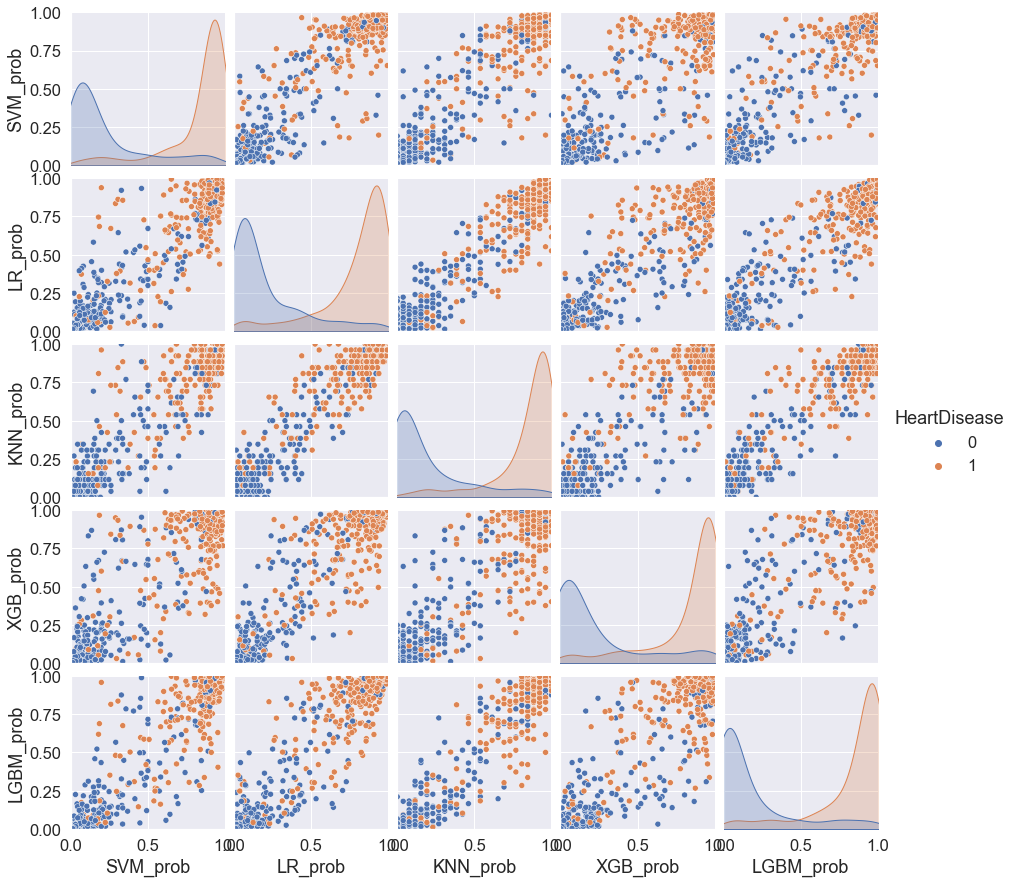

In [55]:
sns.set(font_scale=1.5)
ax=sns.pairplot(data_tmp,vars=['SVM_prob','LR_prob','KNN_prob','XGB_prob','LGBM_prob'],hue='HeartDisease')
ax.set(xlim=(0,1),ylim=(0,1))
plt.show()

In [41]:
?sns.pairplot

In [45]:
data_tmp.to_csv('predict_distribution.csv')

In [294]:
pd.set_option('display.max_columns', 100)
data_tmp.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,G_ChestPainType,K_ChestPain_group,CholCat,G_CholCat,G_H_risk,H_Risk2_,MaxHR_2,M_ST_Nomal-or-Error,SS_Age,SS_Cholesterol,SS_RestingBP,SS_MaxHR,SS_Oldpeak,SS_MaxHR_2,ASY,ATA,NAP,TA,LVH,Normal,ST,Down,Flat,Up,G_ASY,G_ATA,G_TA+NAP,K_ASY,K_ATA/TA,K_NAP,chol1_0,chol1_1,chol1_2,chol1_3,chol0,chol1,chol2,chol3,chol4,Risk0,Risk1,Risk2,Risk3,Risk4,Risk2_0,Risk2_1,Risk2_2,Risk2_3,Risk2_4,Risk2_5
0,56,1,3,155,342,1,0,150,1,3.0,1,1,2,2,2,3,4,5,17.8,1.0,0.256306,1.323176,1.272672,0.512265,1.959903,-0.628610,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,55,0,1,130,394,0,2,150,0,0.0,2,0,0,1,2,3,2,0,18.5,0.0,0.151431,1.796972,-0.116784,0.512265,-0.809353,-0.597872,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
2,47,1,0,110,0,1,0,120,1,0.0,1,1,1,0,4,4,0,4,54.1,0.0,-0.687567,-1.792941,-1.228348,-0.706992,-0.809353,0.965409,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,34,1,3,115,0,1,0,154,0,0.2,2,1,2,2,4,4,2,0,29.2,0.0,-2.050938,-1.792941,-0.950457,0.674833,-0.624736,-0.128009,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,54,0,0,160,201,0,0,163,0,0.0,2,0,1,0,1,1,2,0,6.2,0.0,0.046557,0.038461,1.550563,1.040610,-0.809353,-1.137994,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0


In [295]:
# 予測結果の格納用のnumpy行列を作成
#test_preds = np.zeros((len(y), 5))
#test_preds = []


#2段目モデルの学習

acc_list = []
acc_list_train = []

#X_train_cv = test_probs       #予測確率で学習
X_train_cv = test_preds      #予測値で学習

y_train_cv = y

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_test = list(range(len(test_preds)))

kf = KFold(n_splits = 5)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in kf.split(row_no_test, y_train_cv):

    
    # 学習用 メタモデル(LC)      1段目のモデル精度より高い　メタモデル候補
    clf_LC = LogisticRegression(penalty='l2')
    clf_LC.fit(X_train_cv.loc[train_cv_no,:], y_train_cv.loc[train_cv_no])
    
    y_pred = clf_LC.predict(X_train_cv.loc[eval_cv_no,:])
    y_pred_train = clf_LC.predict(X_train_cv.loc[train_cv_no,:])
    
    
    """
    # 学習用 メタモデル(RFC)      1段目のモデル精度より低い
    clf_RFC = RandomForestClassifier()
    clf_RFC.fit(X_train_cv.loc[train_cv_no,:], y_train_cv.loc[train_cv_no])
    
    y_pred = clf_RFC.predict(X_train_cv.loc[eval_cv_no,:])
    y_pred_train = clf_RFC.predict(X_train_cv.loc[train_cv_no,:])
    """
    
    """
    # 学習用 メタモデル(SVM)      1段目のモデル精度より低い
    clf_SVM = SVC()
    clf_SVM.fit(X_train_cv.loc[train_cv_no,:], y_train_cv.loc[train_cv_no])
    
    y_pred = clf_SVM.predict(X_train_cv.loc[eval_cv_no,:])
    y_pred_train = clf_SVM.predict(X_train_cv.loc[train_cv_no,:])
    """
    
    """
    # 学習用 メタモデル(LGB)      1段目のモデル精度より低い
    clf_LGB = lgb.LGBMClassifier()
    clf_LGB.fit(X_train_cv.loc[train_cv_no,:], y_train_cv.loc[train_cv_no]) # モデルの学習
    
    y_pred = clf_LGB.predict(X_train_cv.loc[eval_cv_no,:])
    y_pred_train = clf_LGB.predict(X_train_cv.loc[train_cv_no,:])
    """
    
    """
    # 学習用 メタモデル(KNN)      1段目のモデル精度より低い
    clf_KNN = KNeighborsClassifier()
    clf_KNN.fit(X_train_cv.loc[train_cv_no,:], y_train_cv.loc[train_cv_no]) # モデルの学習
    
    y_pred = clf_KNN.predict(X_train_cv.loc[eval_cv_no,:])
    y_pred_train = clf_KNN.predict(X_train_cv.loc[train_cv_no,:])
    """
    
    acc = accuracy_score(y_train_cv.loc[eval_cv_no], y_pred)
    acc_list.append(acc)
    
    acc_train = accuracy_score(y_train_cv.loc[train_cv_no], y_pred_train)
    acc_list_train.append(acc_train)

    print('Accuracy:', acc)
    

Accuracy: 0.875968992248062
Accuracy: 0.8992248062015504
Accuracy: 0.9296875
Accuracy: 0.8671875
Accuracy: 0.875


In [296]:
print("test score\n", np.mean(acc_list), np.mean(SVM_accuracies),
np.mean(LR_accuracies), np.mean(KNN_accuracies),
np.mean(RFC_accuracies), np.mean(XGB_accuracies))

print("")

print("train score\n", np.mean(acc_list_train), np.mean(SVM_accuracies_train),
np.mean(LR_accuracies_train), np.mean(KNN_accuracies_train),
np.mean(RFC_accuracies_train), np.mean(XGB_accuracies_train))

test score
 0.8894137596899224 0.8863008720930232 0.8847504844961239 0.8910004844961239 0.8800993217054263 0.8505087209302327

train score
 0.8917446014517487 0.9088758428713375 0.8851252645231756 0.8905742523190814 0.906541212521143 0.9263984648174697


In [680]:
#1段目モデルの学習

In [297]:
print("")
# SVMの訓練を実行
SVM_accuracy, SVM_accuracy_train, SVM_prob, SVM_pred, SVM = Svm_set(X_train, y_train,X_train, y_train)

# LRの訓練を実行
lr_accuracy, lr_accuracytrain, lr_prob, lr_pred, LR = Lr_set(X_train, y_train,X_train, y_train)
                                            

# KNNの訓練を実行
knn_accuracy, knn_accuracy_train, knn_prob, knn_pred, KNN = Knn_set(X_train, y_train,X_train, y_train)
                                                

# RFCの訓練を実行
rfc_accuracy, rfc_accuracy_train, rfc_prob, rfc_pred, RFC = Rfc_set(X_train, y_train,X_train, y_train)


# XGBの訓練を実行
xgb_accuracy, xgb_accuracy_train, xgb_prob, xgb_pred, XGB = Xgb_set(X_train, y_train,X_train, y_train)

# LGBMの訓練を実行
lgbm_accuracy, lgbm_accuracy_train, lgbm_prob, lgbm_pred, LGBM = LGBM_set(X_train, y_train,X_train, y_train)

print("")


SVM Accuracy: 0.9034267912772586
LR Accuracy: 0.8862928348909658
KNN Accuracy: 0.8909657320872274
RFC Accuracy: 0.9049844236760125
XGB Accuracy: 0.9392523364485982
LGBM Accuracy: 0.9517133956386293



In [304]:
#本番の一段目の予測確率を入れる枠
test_honban = pd.DataFrame(np.zeros((len(data_test), 6*1*1)))

#本番の一段目の予測値を入れる枠
test_honban_pred = pd.DataFrame(np.zeros((len(data_test), 6*1*1)))


In [306]:
#テストの予測
#SVM

feature = [
    #Age
            "Age",
    #Sex
            "Sex",
    #ChestPainType
                "ASY",
                "ATA",
                "NAP",
                "TA",
    #RestingBP
            "RestingBP",
    #Cholesterol
    #FastingBS
            "FastingBS",
    #RestingECG
                "LVH",
                "Normal",
                "ST",
    #MaxHR
            "MaxHR",
    #ExerciseAngina
            "ExerciseAngina",
    #Oldpeak
            "Oldpeak",
    #ST_Slope
                "Down",
                "Flat",
                "Up",
    #Oldpeak&ST_Slope
            "M_ST_Nomal-or-Error"
          ]
    
    
X_test = data_test[feature]

#trainの予測値
#train_pred = clf_SVM.predict(X_train)
y_pred = SVM.predict(X_test)
y_proba = SVM.predict_proba(X_test)
y_proba_1 = y_proba[:,1].tolist()

test_honban.iloc[:, 0] = y_proba_1
test_honban_pred.iloc[:, 0] = y_pred

accuracy = accuracy_score(y_test, y_pred)
print('SVM Accuracy:', accuracy)

SVM Accuracy: 0.9080996884735203


In [307]:
#LR
features = ['SS_Age','Sex','SS_RestingBP','FastingBS','SS_MaxHR_2',
            'ExerciseAngina','chol0','chol4',
            'Risk0', 'Risk1', 'Risk2', 'Risk3', 'Risk4']


#変数
X_test = data_test[features]

#trainの予測値
#train_pred = clf_LC.predict(X_train)

y_pred = LR.predict(X_test)
y_proba = LR.predict_proba(X_test)
y_proba_1 = y_proba[:,1].tolist()

test_honban.iloc[:, 1] = y_proba_1
test_honban_pred.iloc[:, 1] = y_pred

accuracy = accuracy_score(y_test, y_pred)
print('LR Accuracy:', accuracy)

LR Accuracy: 0.8862928348909658


In [309]:
#KNN

#ラベル特徴量
feature = ["SS_Age", "Sex", "K_ChestPain_group", "SS_RestingBP", "FastingBS", "RestingECG",
            "SS_MaxHR", "ExerciseAngina", "H_Risk2_","CholCat"]
    
#変数

X_test = data_test[feature]

#trainの予測値
#train_pred = KNN.predict(X_train)

y_pred = KNN.predict(X_test)
y_proba = KNN.predict_proba(X_test)
y_proba_1 = y_proba[:,1].tolist()

test_honban.iloc[:, 2] = y_proba_1
test_honban_pred.iloc[:, 2] = y_pred

accuracy = accuracy_score(y_test, y_pred)
print('KNN Accuracy:', accuracy)

KNN Accuracy: 0.8940809968847352


In [342]:
 #ラベル特徴量

feature = ["Age", "Sex", "G_ChestPainType", "RestingBP", "G_CholCat",
           "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "H_Risk2_"
          ]

#変数
X_test = data_test[feature]

y_pred = RFC.predict(X_test)
y_proba = RFC.predict_proba(X_test)
y_proba_1 = y_proba[:,1].tolist()

test_honban.iloc[:, 3] = y_proba_1
test_honban_pred.iloc[:, 3] = y_pred

accuracy = accuracy_score(y_test, y_pred)
print('RFC Accuracy:', accuracy)

RFC Accuracy: 0.9065420560747663


In [344]:
#XGB

feature = ["Age", "Sex", "RestingBP", "Cholesterol", "FastingBS",
           "RestingECG", "MaxHR", "ExerciseAngina", "G_H_risk"
          ]

#変数

X_test = data_test[feature]


y_pred = XGB.predict(X_test)
y_proba = XGB.predict_proba(X_test)
y_proba_1 = y_proba[:,1].tolist()

test_honban.iloc[:, 4] = y_proba_1
test_honban_pred.iloc[:, 4] = y_pred

accuracy = accuracy_score(y_test, y_pred)
print('XGB Accuracy:', accuracy)

XGB Accuracy: 0.9236760124610592


In [347]:
#LGBM
#ラベル特徴量
feature = ["Age", "Sex", "G_ChestPainType","RestingBP", "Cholesterol", "FastingBS",
           "RestingECG", "ExerciseAngina", "H_Risk2_",'MaxHR'
          ]

X_test = data_test[feature]


#trainの予測値
#train_pred = XGB.predict(X_train)

y_pred = LGBM.predict(X_test)
y_proba = LGBM.predict_proba(X_test)
y_proba_1 = y_proba[:,1].tolist()

accuracy = accuracy_score(y_test, y_pred)
test_honban.iloc[:, 5] = y_proba_1
print('LGBM Accuracy:', accuracy)

LGBM Accuracy: 0.9485981308411215


In [348]:
#2段目：XGBの実行、予測、ACCをprint

#X_test_cv = test_honban         #予測確率で判断
X_test_cv = test_honban_pred     #予測値で判断

y_test_cv = y_data_test



#メタモデル(LC)
y_pred = clf_LC.predict(X_test_cv)


"""
#メタモデル(SVM)
y_pred = clf_SVM.predict(X_test_cv)
"""


#test_preds.extend(y_pred)
acc = accuracy_score(y_test_cv, y_pred)

print('Accuracy:', acc)


Accuracy: 0.9049844236760125
